In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sidetable # si nos da un error este comando es por no tenerlo instalado
from datetime import date, datetime
from scipy import stats
from sklearn.preprocessing import StandardScaler
pd.options.display.max_columns=None
# establecer el tamaño de nuestras figuras
plt.rcParams["figure.figsize"] = (10,8)

In [2]:
df = pd.read_csv('data/totales_encod.csv', index_col = 0)
df.head(2)

,registro,clima,temperatura,sens_termica,humedad,viento,total,fecha_nueva,festividad,festividad_1,mes_bueno,dia_semana_nuevo,no_laboral_nuevo,año_map,estacion_map
0,1,2,14.1,18.2,81.0,10.7,985,2018-01-01,New Year's Day,1,1,0,0,0,0
1,2,2,14.9,17.7,70.0,16.7,801,2018-01-02,NaN,0,1,1,1,0,0


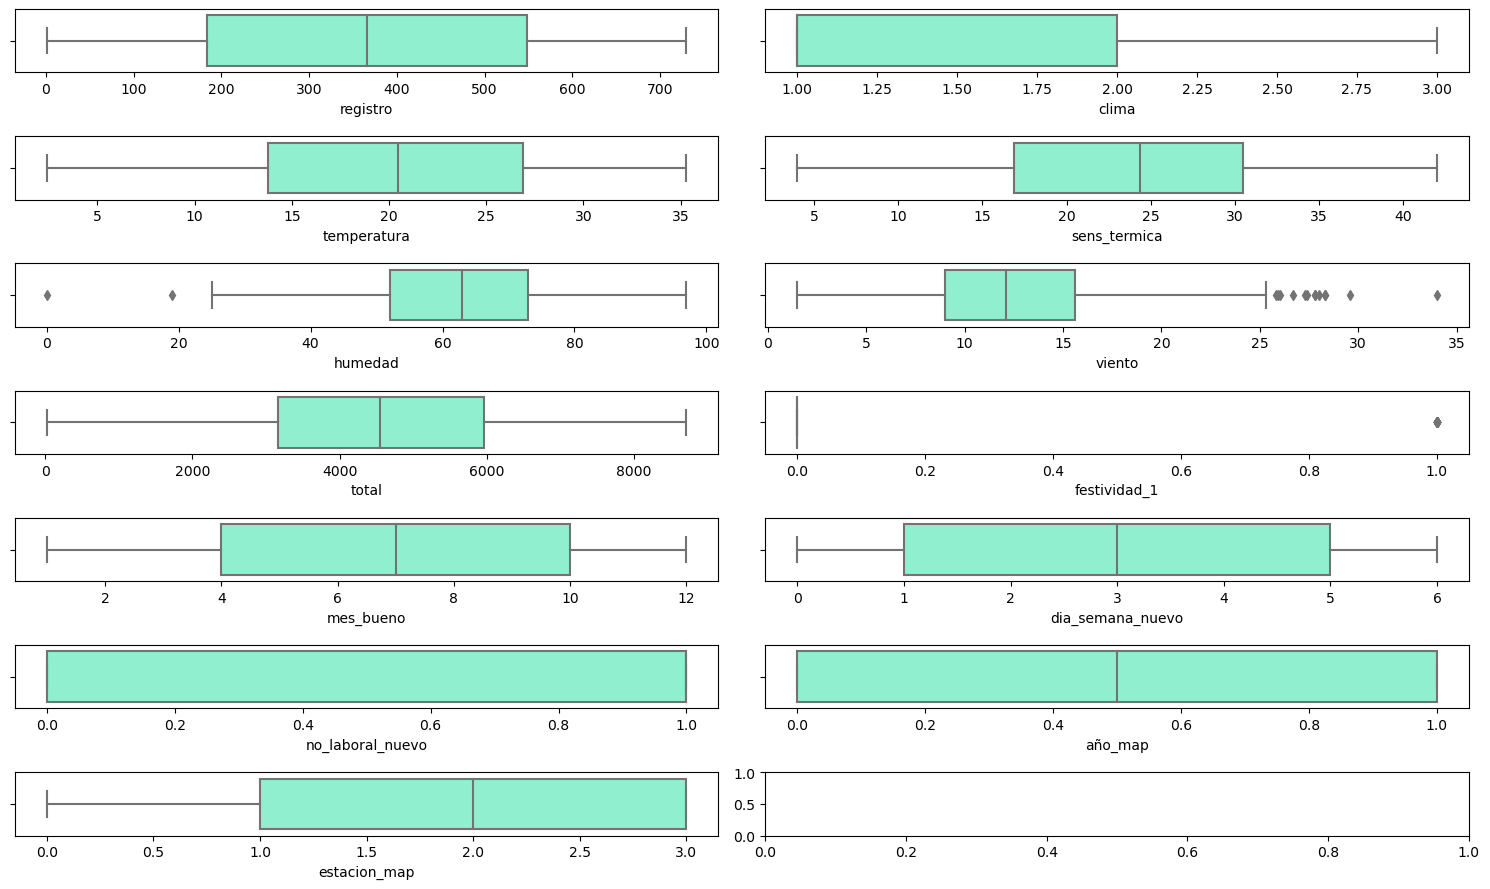

In [3]:
fig, axes = plt.subplots(7,2, figsize=(15,9))

axes = axes.flat
numericas = df.select_dtypes(include = np.number)
for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], data = df, ax=axes[indice], color = "aquamarine"); 

    
plt.tight_layout()
plt.show()

Eliminamos los outliers de la columna 'viento'

In [4]:
df['viento'].mean()

12.764794520547941

In [5]:
df['viento'].median()

12.1

In [6]:

def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    ##tenemos el diccionario de indices de las filas que tienen outliers, pero lo ideal seria que extraer los dataframes para cargas y trabaar con ese dataframe.
    ##dicc_dataframes={}

    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(dataframe[col], 25)
        Q3 = np.nanpercentile(dataframe[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        ##aqui creo una key que va a ser diferente por cada columna y cuyo value sea el dataframe que acao de crear. Keys seran los nombres de als coumnas y value los dataframes.
        ##dicc_dataframes[col]=outliers_data
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    
    return dicc_indices #, dicc_dataframes

In [7]:
lista_columnas = ['viento']

In [8]:
ind_viento = detectar_outliers(lista_columnas, df)

In [9]:
ind_viento

{'viento': [44, 49, 93, 94, 292, 382, 407, 420, 431, 432, 449, 665, 720]}

In [10]:
for k, v in ind_viento.items():
    media = df[k].mean() # calculamos la media para cada una de las columnas que tenemos en nuestro diccionario
    for i in v:# iteremos por la lista de valores para cada columna
        df.loc[i,k] = media # usando el loc, reemmplazamos los valores de los outliers por la media que hemos calculado al inicio

Estandarizamos 

In [14]:
scaler = StandardScaler()

In [15]:
numericas = df.select_dtypes(include = np.number)

In [16]:
df.columns

Index(['registro', 'clima', 'temperatura', 'sens_termica', 'humedad', 'viento',
       'total', 'fecha_nueva', 'festividad', 'festividad_1', 'mes_bueno',
       'dia_semana_nuevo', 'no_laboral_nuevo', 'año_map', 'estacion_map'],
      dtype='object')

In [18]:
numericas.drop(["total", "registro" , "clima", "festividad_1", "mes_bueno", "dia_semana_nuevo", "no_laboral_nuevo"], axis = 1, inplace = True)

numericas.head(2)

,temperatura,sens_termica,humedad,viento,año_map,estacion_map
0,14.1,18.2,81.0,10.7,0,0
1,14.9,17.7,70.0,16.7,0,0


In [20]:
numericas.drop(["año_map", 'estacion_map'], axis = 1, inplace = True)

In [21]:
scaler.fit(numericas)

StandardScaler()

In [22]:
# transformamos los datos

X_escaladas = scaler.transform(numericas)

In [23]:

numericas_estandar = pd.DataFrame(X_escaladas, columns = numericas.columns)
numericas_estandar.head(2)

,temperatura,sens_termica,humedad,viento
0,-0.828948,-0.678635,1.279463,-0.376545
1,-0.722312,-0.740034,0.507498,0.882110


In [24]:
for columna in numericas_estandar.columns:
    print(f'La media de la columna {columna} es:  {numericas_estandar[columna].mean()}')
    print(f'La desviación estándar de la columna {columna} es: {numericas_estandar[columna].std()}')
    print("-------------------------------------------------------------")

La media de la columna temperatura es:  -6.387584525240627e-18
La desviación estándar de la columna temperatura es: 1.0006856360078742
-------------------------------------------------------------
La media de la columna sens_termica es:  -5.134401275526751e-16
La desviación estándar de la columna sens_termica es: 1.000685636007875
-------------------------------------------------------------
La media de la columna humedad es:  -9.763879202867816e-17
La desviación estándar de la columna humedad es: 1.0006856360078737
-------------------------------------------------------------
La media de la columna viento es:  1.466863160617758e-16
La desviación estándar de la columna viento es: 1.000685636007874
-------------------------------------------------------------


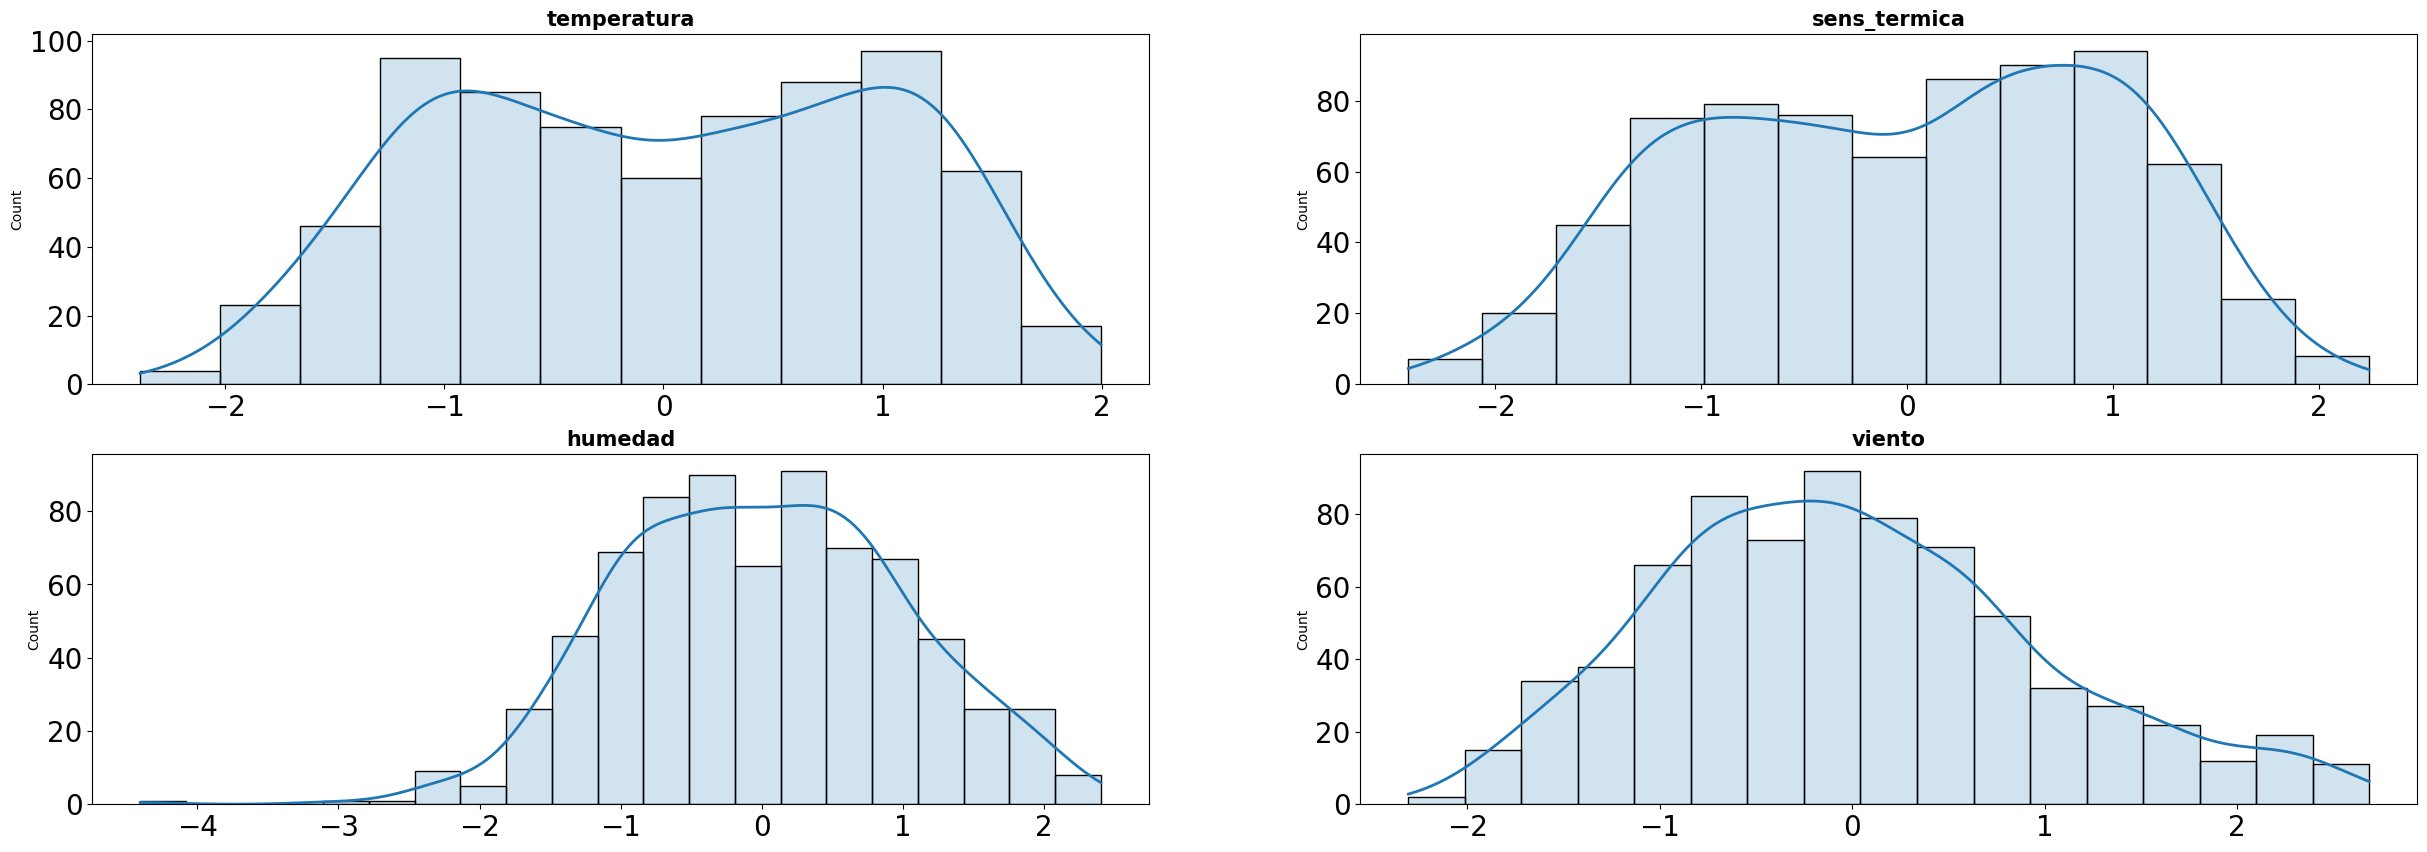

In [25]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))

columnas_estandar = numericas_estandar.columns
axes = axes.flat


for i, colum in enumerate(columnas_estandar): 
    sns.histplot(
        data = numericas_estandar,
        x = colum,
        kde = True,  
        line_kws = {"linewidth": 2}, 
        alpha = 0.2, 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")

In [26]:
df[numericas_estandar.columns] = numericas_estandar
df.head()

,registro,clima,temperatura,sens_termica,humedad,viento,total,fecha_nueva,festividad,festividad_1,mes_bueno,dia_semana_nuevo,no_laboral_nuevo,año_map,estacion_map
0,1,2,-0.828948,-0.678635,1.279463,-0.376545,985,2018-01-01,New Year's Day,1,1,0,0,0,0
1,2,2,-0.722312,-0.740034,0.507498,0.882110,801,2018-01-02,NaN,0,1,1,1,0,0
2,3,1,-1.642047,-1.746977,-1.317148,0.861132,1349,2018-01-03,NaN,0,1,2,1,0,0
3,4,1,-1.615388,-1.611900,-0.264468,-0.376545,1562,2018-01-04,NaN,0,1,3,1,0,0
4,5,1,-1.468763,-1.501382,-1.317148,0.001051,1600,2018-01-05,NaN,0,1,4,1,0,0


In [27]:
df.to_csv("data/totales_estand_cod.csv")